In [3]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from skfeature.function.similarity_based import fisher_score
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
import plotly.express as px
import lightgbm as lgb
import xgboost as xgb
import pickle

# 1. clean dataset


In [4]:
# read csv files
df_input1 = pd.read_csv('input1.csv', sep=';')
df_input2 = pd.read_csv('input2.csv', sep=';')
df_target = pd.read_csv('target.csv', sep=';')

print(df_input1.shape) #(27936, 6)
print(df_input2.shape) #(1164, 2)
print(df_target.shape) #(1463, 2)

(27936, 6)
(1164, 2)
(1463, 2)


In [5]:
# discript inputs and outputs (to make sure that there is no missing data nor extreme outliers)
print(df_input2.describe())
print(df_input1.describe())
print(df_target.describe())

       DT_DEMO_Inlet_Brightness
count               1164.000000
mean                  83.407413
std                    2.588630
min                   74.675075
25%                   81.789047
50%                   83.342828
75%                   85.090774
max                   91.451909
       DT_DEMO_InletPressure  DT_DEMO_Temperature    DT_DEMO_PH  \
count           27936.000000         27936.000000  27936.000000   
mean              850.234605            70.001295     10.687645   
std                 6.677961             0.376114      0.217029   
min               827.762023            68.760701      9.877040   
25%               845.684225            69.744680     10.539314   
50%               850.285487            70.000294     10.686459   
75%               854.864148            70.259245     10.835738   
max               874.359938            71.493898     11.450929   

       DT_DEMO_Peroxide  DT_DEMO_Soda  
count      27936.000000  27936.000000  
mean          20.063679     

In [6]:
# the first column is the time stamp
df_input1['time_stamp'] = pd.to_datetime(df_input1["Unnamed: 0"], format='%d.%m.%Y %H:%M')
df_input2['time_stamp'] = pd.to_datetime(df_input2["Unnamed: 0"], format='%d.%m.%Y %H:%M')
df_target['time_stamp'] = pd.to_datetime(df_target["Unnamed: 0"], format='%d.%m.%Y %H:%M')
df_input1 = df_input1.drop(columns=["Unnamed: 0"])
df_input2 = df_input2.drop(columns=["Unnamed: 0"])
df_target = df_target.drop(columns=["Unnamed: 0"])

# keep target data with date upto 2020-12-07 (as inputs are all upto 2020-12-06)
df_target = df_target[df_target['time_stamp'] < '2020-12-08']

print(df_input1.shape) # (27936, 6)
print(df_input2.shape) # (1164, 2)
print(df_target.shape) # (1163, 2)

(27936, 6)
(1164, 2)
(1175, 2)


In [7]:
# check nan values
print(df_input1.isnull().sum())
print(df_input2.isnull().sum())
print(df_target.isnull().sum())

DT_DEMO_InletPressure    0
DT_DEMO_Temperature      0
DT_DEMO_PH               0
DT_DEMO_Peroxide         0
DT_DEMO_Soda             0
time_stamp               0
dtype: int64
DT_DEMO_Inlet_Brightness    0
time_stamp                  0
dtype: int64
DT_DEMO_Target_Brightness    0
time_stamp                   0
dtype: int64


# 2. Feature extraction and selection

In [8]:
#in input1, calculate the mean, std, median etc. of the values every 2 hours, for example, the mean of the values from 00:00 to 02:00 should be the value of 00:00
df_input1_mean = df_input1.groupby(pd.Grouper(key='time_stamp', freq='2H')).mean()
df_input1_std = df_input1.groupby(pd.Grouper(key='time_stamp', freq='2H')).std()
df_inpput1_median = df_input1.groupby(pd.Grouper(key='time_stamp', freq='2H')).median()
df_input1_max = df_input1.groupby(pd.Grouper(key='time_stamp', freq='2H')).max()
df_input1_min = df_input1.groupby(pd.Grouper(key='time_stamp', freq='2H')).min()

#rename the columns, keep time_stamp, and all the others should be add "_mean" or "_std etc.
df_input1_mean.columns = ['DT_DEMO_InletPressure_mean', 'DT_DEMO_Temperature_mean', 'DT_DEMO_PH_mean', 'DT_DEMO_Peroxide_mean', 'DT_DEMO_Soda_mean']
df_input1_std.columns = ['DT_DEMO_InletPressure_std', 'DT_DEMO_Temperature_std', 'DT_DEMO_PH_std', 'DT_DEMO_Peroxide_std', 'DT_DEMO_Soda_std']
df_inpput1_median.columns = ['DT_DEMO_InletPressure_median', 'DT_DEMO_Temperature_median', 'DT_DEMO_PH_median', 'DT_DEMO_Peroxide_median', 'DT_DEMO_Soda_median']
df_input1_max.columns = ['DT_DEMO_InletPressure_max', 'DT_DEMO_Temperature_max', 'DT_DEMO_PH_max', 'DT_DEMO_Peroxide_max', 'DT_DEMO_Soda_max']
df_input1_min.columns = ['DT_DEMO_InletPressure_min', 'DT_DEMO_Temperature_min', 'DT_DEMO_PH_min', 'DT_DEMO_Peroxide_min', 'DT_DEMO_Soda_min']

#merge all the dataframes
df_input1 = pd.merge(df_input1_mean, df_input1_std, on='time_stamp', how='left')
df_input1 = pd.merge(df_input1, df_inpput1_median, on='time_stamp', how='left')
df_input1 = pd.merge(df_input1, df_input1_max, on='time_stamp', how='left')
df_input1 = pd.merge(df_input1, df_input1_min, on='time_stamp', how='left')
df_input = pd.merge(df_input1, df_input2, on='time_stamp', how='left')

In [9]:
# delay is an list of datetime objects, either 1h45, 3h45 or 5h45
propogation_delays = [
    '01:45:00',
    '03:45:00',
    '05:45:00',
]

# define a function if the nth row of a dataframe has the same date and time as the input, return n
def find_delay_item(time_stamp, df, on_col="time_stamp", return_col="DT_DEMO_Target_Brightness", delay=None):
    if delay is None:
        delay = '00:00:00'
    delay = pd.Timedelta(delay)
    time_stamp = time_stamp + delay

    for i in range(len(df)):
        if df[on_col][i] == time_stamp:
            return df[return_col][i]
    return -1

# define a function if the nth row of a dataframe has the same date and time as the input, return n-1
def find_last_delay_item(time_stamp, df, on_col="time_stamp", return_col="DT_DEMO_Target_Brightness", delay=None):
    if delay is None:
        delay = '00:00:00'
    delay = pd.Timedelta(delay)
    time_stamp = time_stamp + delay

    for i in range(len(df)):
        if df[on_col][i] == time_stamp:
            if i-1 in range(len(df)):
                return df[return_col][i-1]
            else:
                return -1
    return -1

# match the rows in input and target dfs
def get_input_df(delay,df_input,df_target):
    df_input.reset_index(drop=True, inplace=True)
    df_input['target'] = [find_delay_item(df_input['time_stamp'][i], df_target, delay=delay) for i in range(len(df_input))]
    df_input['last_target'] = [find_last_delay_item(df_input['time_stamp'][i], df_target, delay=delay) for i in range(len(df_input))]
    df_input = df_input[df_input["target"]!=-1]
    df_input.reset_index(drop=True, inplace=True)
    return df_input

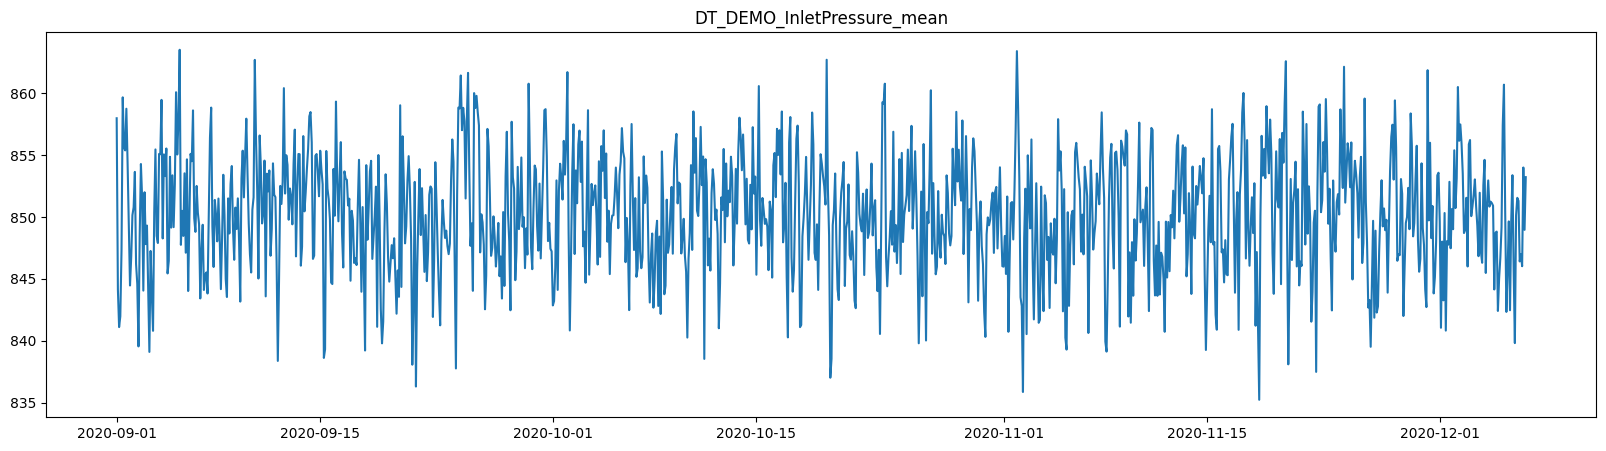

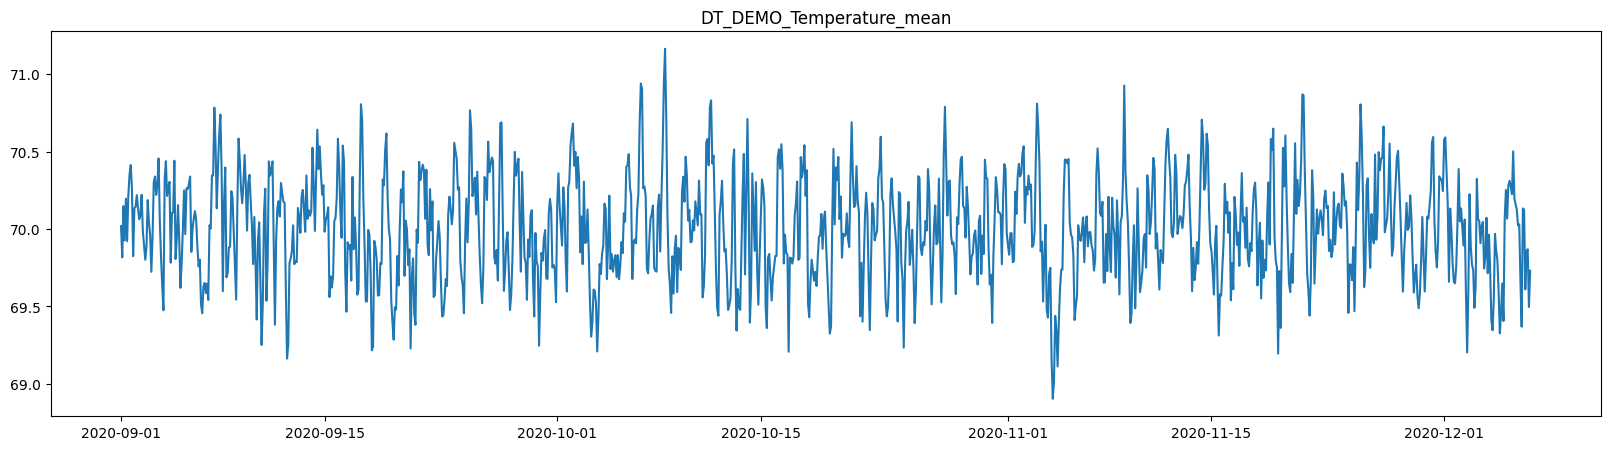

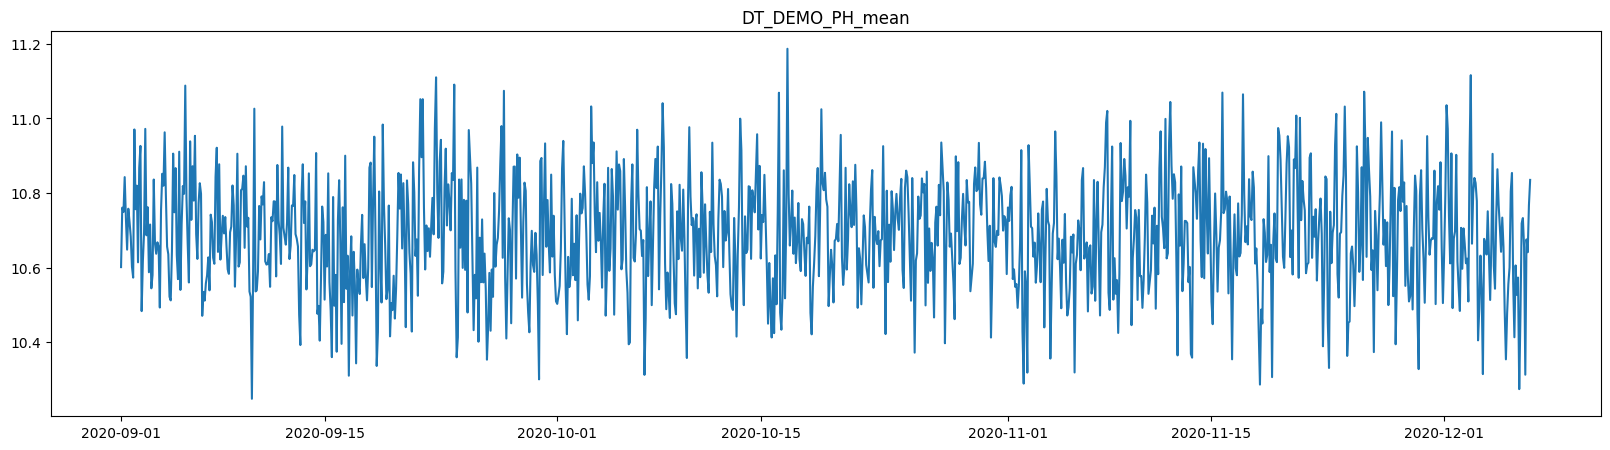

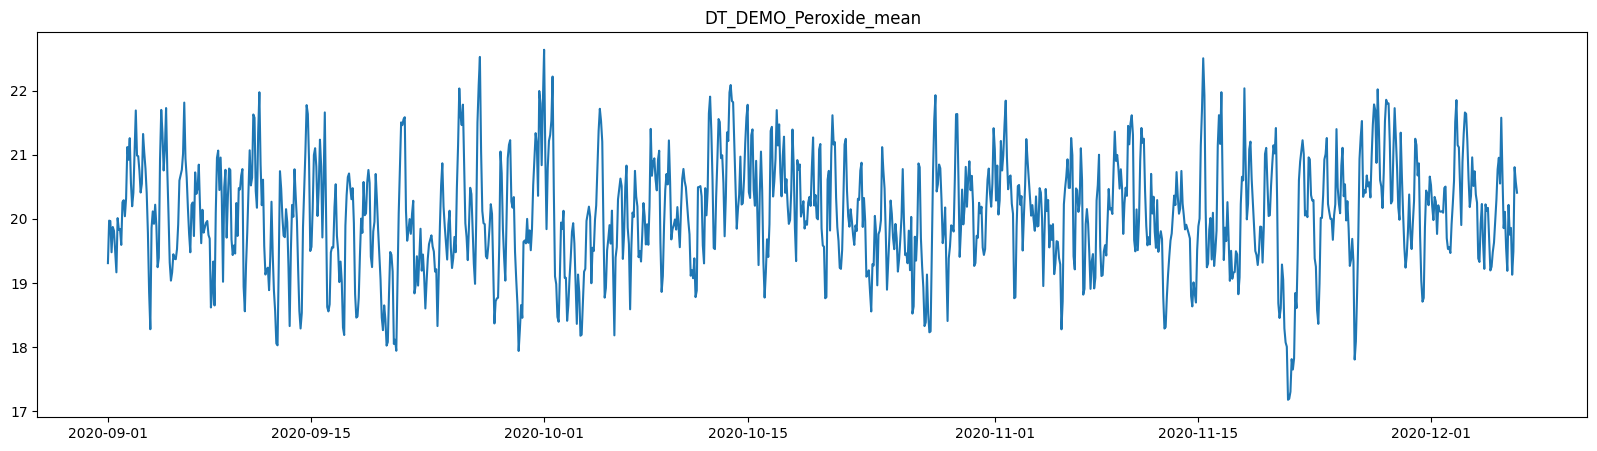

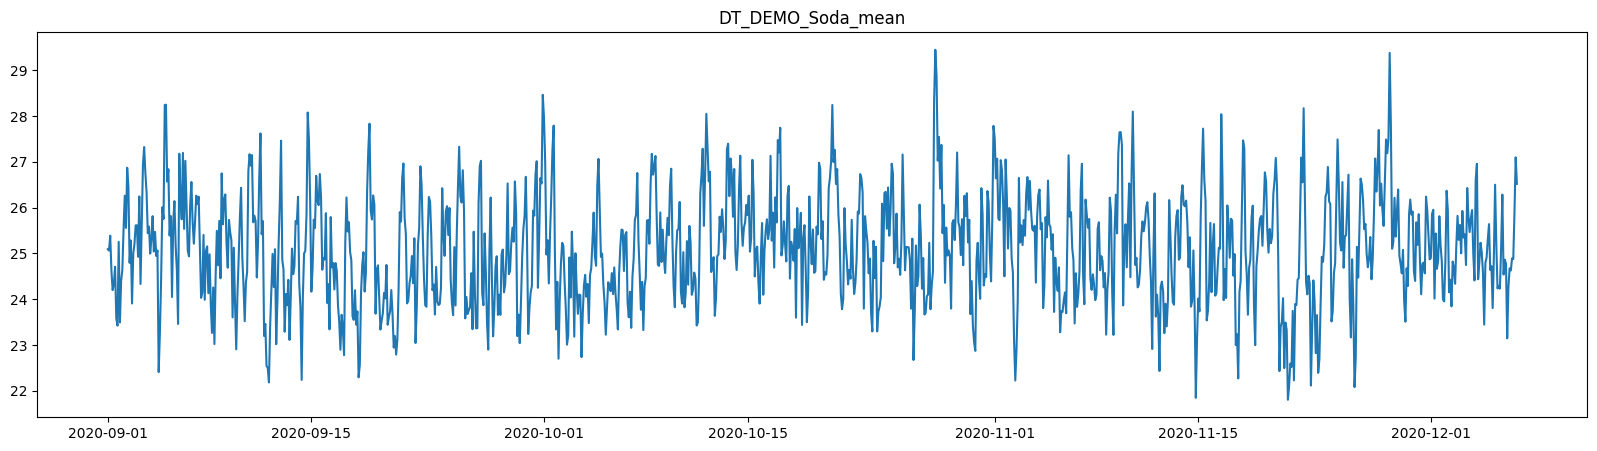

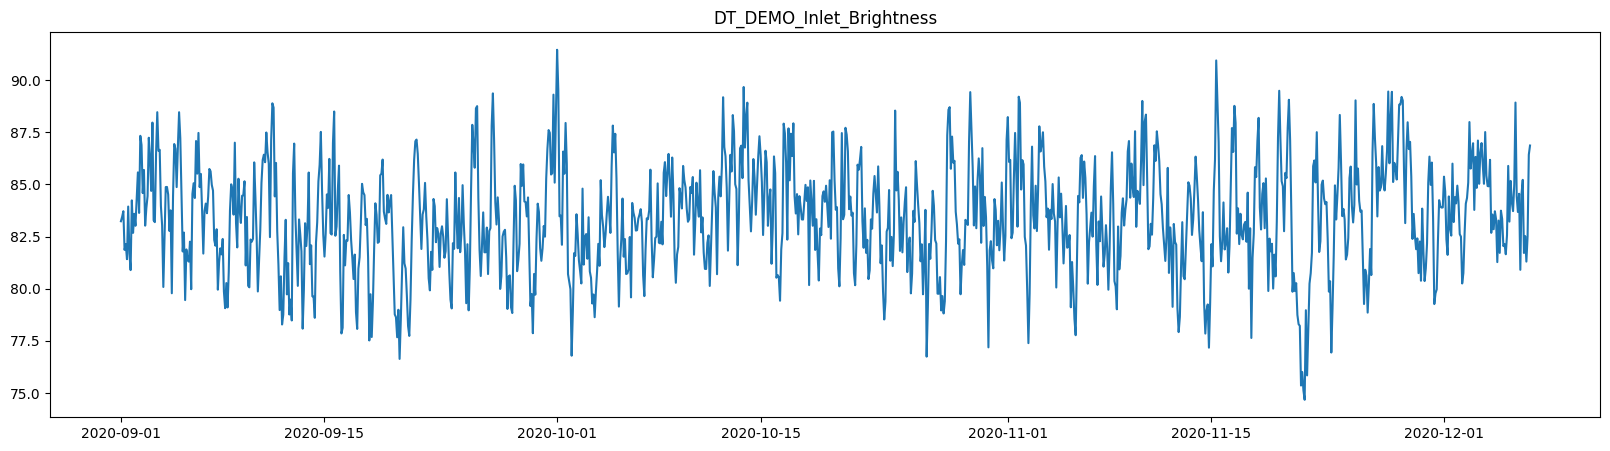

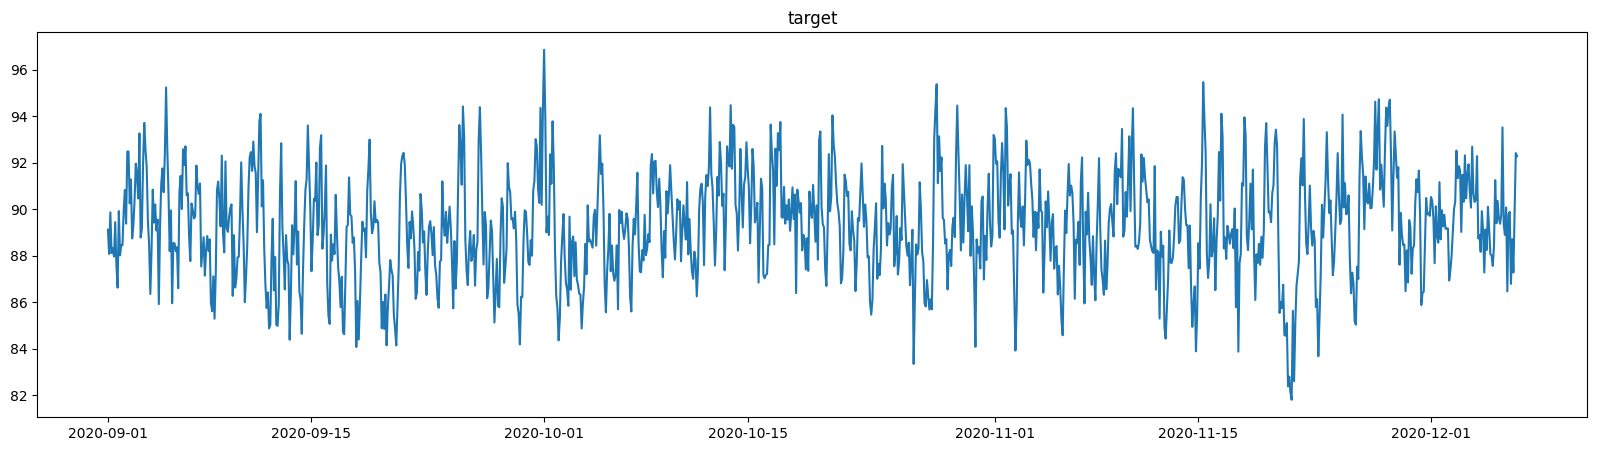

In [10]:
# to draw the time series plot
df_input = get_input_df(propogation_delays[1],df_input,df_target)

def draw_time_series_plot(df_input, feature):
    plt.figure(figsize=(20, 5))
    plt.plot(df_input["time_stamp"], df_input[feature])
    plt.title(feature)
    plt.show()

# draw time series plot of each feature
draw_time_series_plot(df_input, 'DT_DEMO_InletPressure_mean')
draw_time_series_plot(df_input, 'DT_DEMO_Temperature_mean')
draw_time_series_plot(df_input, 'DT_DEMO_PH_mean')
draw_time_series_plot(df_input, 'DT_DEMO_Peroxide_mean')
draw_time_series_plot(df_input, 'DT_DEMO_Soda_mean')
draw_time_series_plot(df_input, 'DT_DEMO_Inlet_Brightness')
draw_time_series_plot(df_input, 'target')

## method 1 : fisher score + correlation

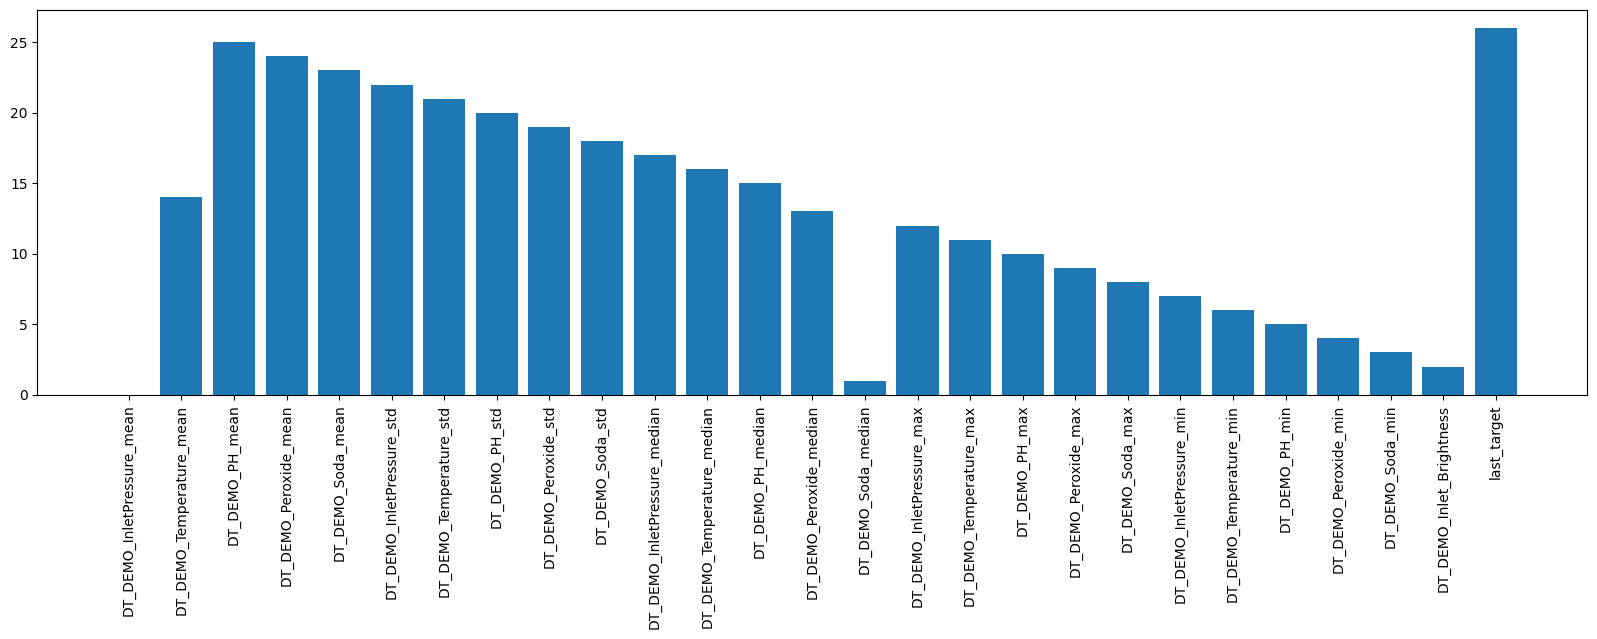

In [11]:
# feature selection
features = np.array(df_input.drop(columns=["time_stamp","target"]))
targets = np.array(["target"])
ranks = fisher_score.fisher_score(features, targets)
# plot the scores with names
plt.figure(figsize=(20, 5))
plt.xticks(rotation=90)
plt.bar(df_input.drop(columns=["time_stamp","target"]).columns, ranks)
plt.show()

# thus, we choose the following features
important_features = ["DT_DEMO_Temperature_mean", "DT_DEMO_PH_mean", "DT_DEMO_Peroxide_mean", "DT_DEMO_Soda_mean", "DT_DEMO_InletPressure_mean", "DT_DEMO_InletPressure_std", "DT_DEMO_Temperature_std", "DT_DEMO_PH_std", "DT_DEMO_Peroxide_std", "DT_DEMO_Soda_std", "DT_DEMO_Temperature_median", "DT_DEMO_PH_median", "DT_DEMO_Peroxide_median"]
features = np.array(df_input[important_features])

<Axes: >

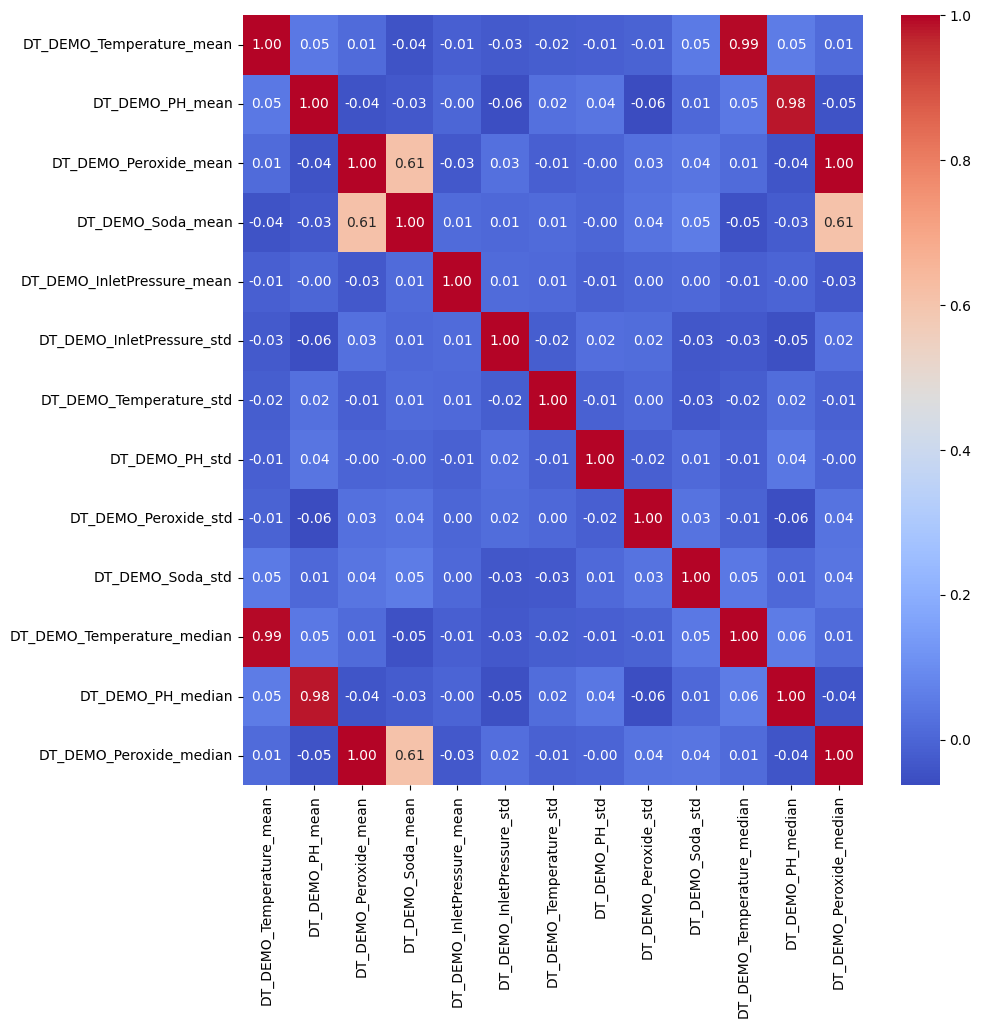

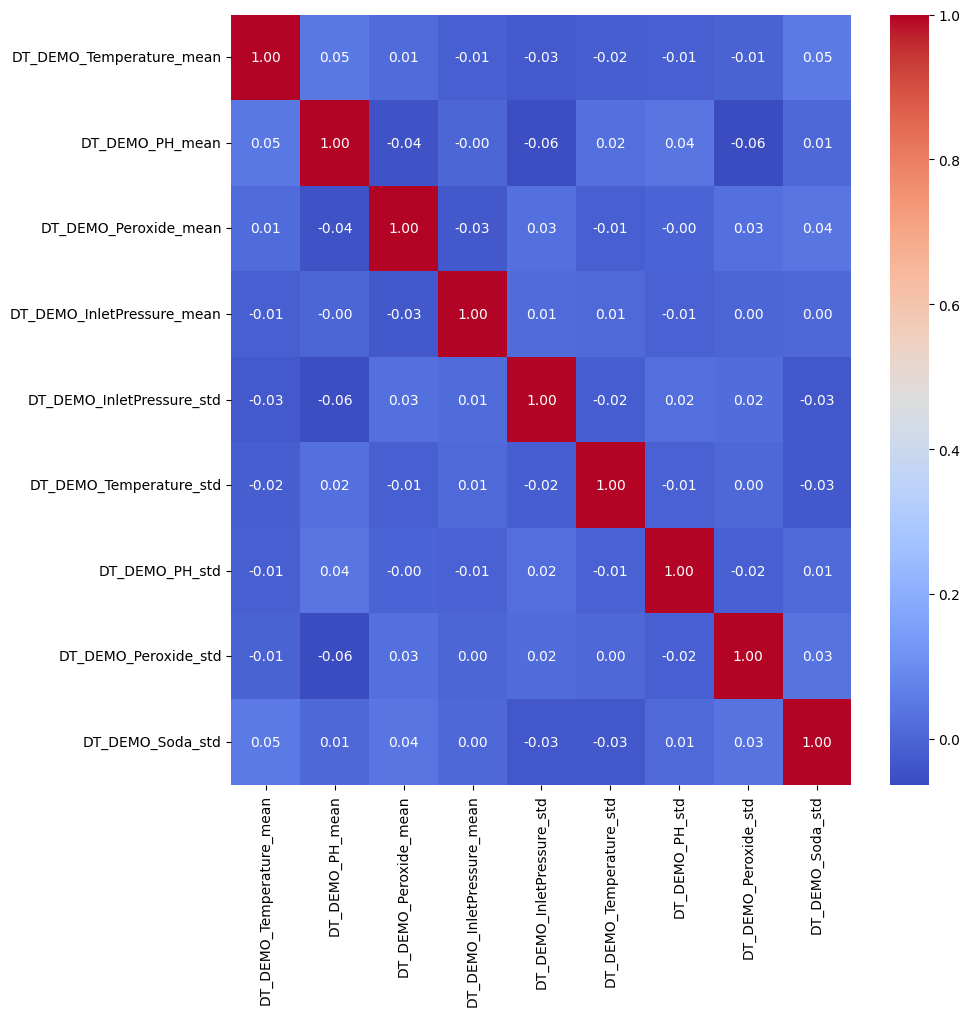

In [12]:
#check correlation between features
plt.figure(figsize=(10, 10))
correlation_matrix = df_input[important_features].corr()

# Use seaborn's heatmap for better visualization and annotation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# therefore we can drop all the median features (which are highly correlated with mean features , the last target and DT_DEMO_Soda_mean)
important_features = ["DT_DEMO_Temperature_mean", "DT_DEMO_PH_mean", "DT_DEMO_Peroxide_mean", "DT_DEMO_InletPressure_mean", "DT_DEMO_InletPressure_std", "DT_DEMO_Temperature_std", "DT_DEMO_PH_std", "DT_DEMO_Peroxide_std", "DT_DEMO_Soda_std"]
plt.figure(figsize=(10, 10))
correlation_matrix = df_input[important_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

### train a machine learning network (random forest) to evaluate the extracted features

In [13]:
# train test split with random state 42
def split_dataset(df_input, important_features=None):
    df_input.drop(columns=['time_stamp'], inplace=True)
    df_train, df_test = train_test_split(df_input, test_size=0.2, random_state=42)
    x_train = df_train.drop(columns=['target'])
    y_train = df_train['target']
    x_test = df_test.drop(columns=['target'])
    y_test = df_test['target']
    if important_features is not None:
        x_train = x_train[important_features]
        x_test = x_test[important_features]
    return x_train, y_train, x_test, y_test

# define a function to calculate the metrics
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# define a function to train a random forest regressor
def train_rf(x_train, y_train, x_test, y_test, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=random_state)
    rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred_test = rf.predict(x_test)
    mse_train, mae_train, r2_train = metrics(y_train, y_pred_train)
    mse_test, mae_test, r2_test = metrics(y_test, y_pred_test)
    return rf, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test

In [14]:
# first test which delay time is the best
train_results1 = []
test_results1 = []

for delay in propogation_delays:
    training_dataset = get_input_df(delay, df_input, df_target)
    x_train, y_train, x_test, y_test = split_dataset(training_dataset, important_features)
    rf, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test = train_rf(x_train, y_train, x_test, y_test)
    train_results1.append([delay, mse_train, mae_train, r2_train])
    test_results1.append([delay, mse_test, mae_test, r2_test])
    print("delay: ", delay)
    print("mse_train: ", mse_train)
    print("mae_train: ", mae_train)
    print("r2_train: ", r2_train)
    print("mse_test: ", mse_test)
    print("mae_test: ", mae_test)
    print("r2_test: ", r2_test)
    print("=====================================================")

best_results1 = [train_results1[1], test_results1[1]]

<ipython-input-13-238db2122684>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.drop(columns=['time_stamp'], inplace=True)


delay:  01:45:00
mse_train:  0.541736688055905
mae_train:  0.5814033114998898
r2_train:  0.8958897128882061
mse_test:  3.4431351106961094
mae_test:  1.5059386291158778
r2_test:  0.18888781268672827
delay:  03:45:00
mse_train:  0.24916037050209197
mae_train:  0.3974148600242732
r2_train:  0.9520985957653955
mse_test:  1.4792021702213782
mae_test:  0.9834662989133023
r2_test:  0.6536862448330594
delay:  05:45:00
mse_train:  0.2363747878306379
mae_train:  0.38692767568603526
r2_train:  0.9538061928278535
mse_test:  1.7772325428107274
mae_test:  1.024004267193991
r2_test:  0.6148607260082135


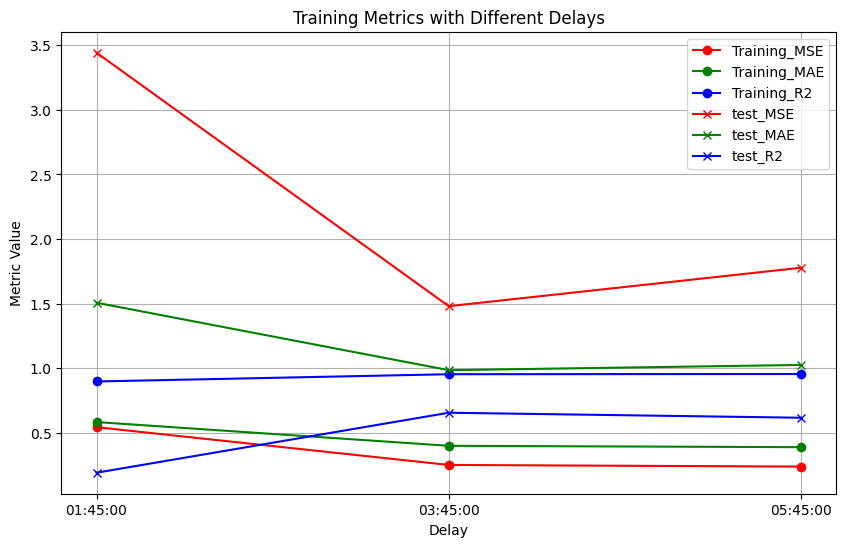

In [15]:
def compare_results(train_results, test_results):
    # Unpack the results into separate lists
    delays, training_mses, training_maes, training_r2s = zip(*train_results)
    delays, test_mses, test_maes, test_r2s = zip(*test_results)
    training_mses = [float(i) for i in training_mses]
    training_maes = [float(i) for i in training_maes]
    training_r2s = [float(i) for i in training_r2s]
    test_mses = [float(i) for i in test_mses]
    test_maes = [float(i) for i in test_maes]
    test_r2s = [float(i) for i in test_r2s]

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(delays, training_mses, marker='o', label='Training_MSE', color='red')
    plt.plot(delays, training_maes, marker='o', label='Training_MAE', color='green')
    plt.plot(delays, training_r2s, marker='o', label='Training_R2', color='blue')
    plt.plot(delays, test_mses, marker='x', label='test_MSE', color='red')
    plt.plot(delays, test_maes, marker='x', label='test_MAE', color='green')
    plt.plot(delays, test_r2s, marker='x', label='test_R2', color='blue')

    # Add labels and legend
    plt.title('Training Metrics with Different Delays')
    plt.xlabel('Delay')
    plt.ylabel('Metric Value')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

compare_results(train_results1, test_results1)

# it seems that we can firstly say that a delay of 3:45:00 is the best choice among these 3 possibilities
delay = '03:45:00'

## method2 : embedded method (let random forest choose feature importance)

In [16]:
# first test which delay time is the best
train_results2 = []
test_results2 = []
rfs = []

for delay in propogation_delays:
    training_dataset = get_input_df(delay, df_input, df_target)
    x_train, y_train, x_test, y_test = split_dataset(training_dataset)
    rf, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test = train_rf(x_train, y_train, x_test, y_test)
    rfs.append(rf)
    train_results2.append([delay, mse_train, mae_train, r2_train])
    test_results2.append([delay, mse_test, mae_test, r2_test])
    print("delay: ", delay)
    print("mse_train: ", mse_train)
    print("mae_train: ", mae_train)
    print("r2_train: ", r2_train)
    print("mse_test: ", mse_test)
    print("mae_test: ", mae_test)
    print("r2_test: ", r2_test)
    print("=====================================================")

best_results2 = [train_results2[1],test_results2[1]]
best_rf = rfs[1]

<ipython-input-13-238db2122684>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.drop(columns=['time_stamp'], inplace=True)


delay:  01:45:00
mse_train:  0.33125711225798765
mae_train:  0.4599430005547326
r2_train:  0.9363394176075372
mse_test:  2.0820128486427127
mae_test:  1.1562616197896978
r2_test:  0.5095324634717842
delay:  03:45:00
mse_train:  0.025061671621866493
mae_train:  0.12462794908262156
r2_train:  0.9951818611413412
mse_test:  0.16910253096774286
mae_test:  0.3296993563953659
r2_test:  0.9604093789972548
delay:  05:45:00
mse_train:  0.203071971806106
mae_train:  0.35577251628313633
r2_train:  0.9603144328810564
mse_test:  1.4670639720004923
mae_test:  0.9292986479343327
r2_test:  0.682076520958715


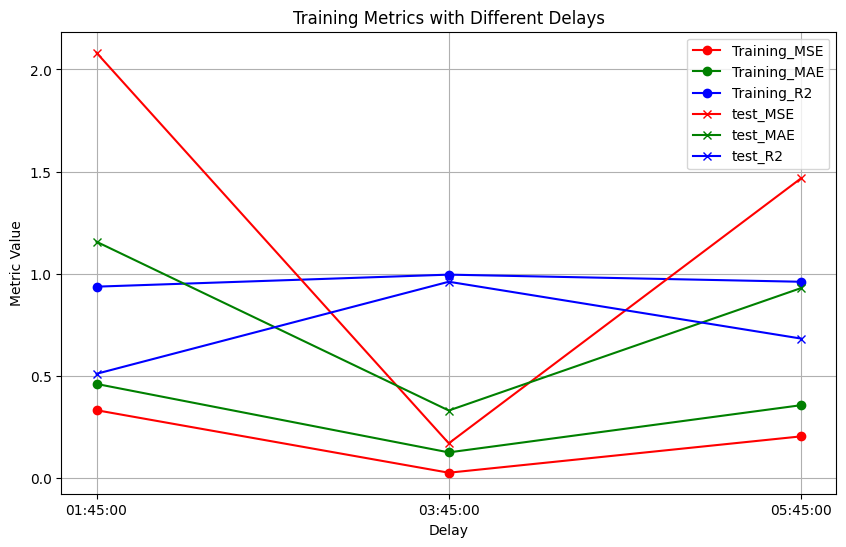

In [17]:
compare_results(train_results2, test_results2)
# it confirms that a delay of 3:45:00 is the best choice among these 3 possibilities

# comparison between 2 methods

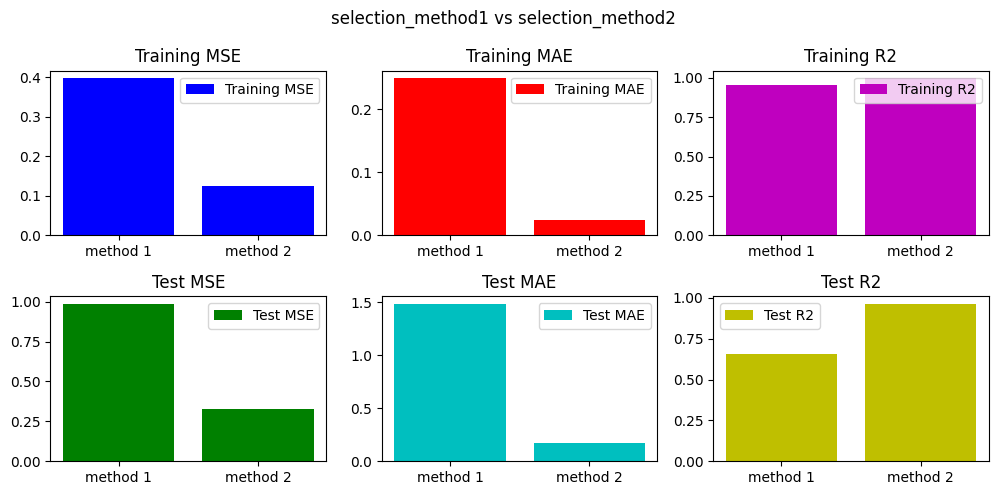

In [18]:
# plot bar figures of best_results1 and bet_results2
def plot_bar(results1, results2, title=None, is_name=0):
    # Unpack the results into separate lists
    name1, training_mae1, training_mse1, training_r21 = results1[0]
    _, test_mae1, test_mse1, test_r21 = results1[1]
    name2, training_mae2, training_mse2, training_r22 = results2[0]
    _, test_mae2, test_mse2, test_r22 = results2[1]
    # tranfer to float
    training_mae1 = float(training_mae1)
    training_mse1 = float(training_mse1)
    training_r21 = float(training_r21)
    test_mae1 = float(test_mae1)
    test_mse1 = float(test_mse1)
    test_r21 = float(test_r21)
    training_mae2 = float(training_mae2)
    training_mse2 = float(training_mse2)
    training_r22 = float(training_r22)
    test_mae2 = float(test_mae2)
    test_mse2 = float(test_mse2)
    test_r22 = float(test_r22)
    # put the values into lists
    training_mses = [training_mse1, training_mse2]
    training_maes = [training_mae1, training_mae2]
    training_r2s = [training_r21, training_r22]
    test_mses = [test_mse1, test_mse2]
    test_maes = [test_mae1, test_mae2]
    test_r2s = [test_r21, test_r22]
    methods = ['method 1', 'method 2']
    if is_name:
      methods = [name1, name2]

    # Create subplots
    fig, axs = plt.subplots(2, 3, figsize=(10, 5))

    # Plot Training MSE
    axs[0, 0].bar(methods, training_mses, color='b', label='Training MSE')
    axs[0, 0].set_title('Training MSE')
    axs[0, 0].legend()

    # Plot Training MAE
    axs[0, 1].bar(methods, training_maes, color='r', label='Training MAE')
    axs[0, 1].set_title('Training MAE')
    axs[0, 1].legend()

    # Plot Training R2
    axs[0, 2].bar(methods, training_r2s, color='m', label='Training R2')
    axs[0, 2].set_title('Training R2')
    axs[0, 2].legend()

    # Plot Test MSE
    axs[1, 0].bar(methods, test_mses, color='g', label='Test MSE')
    axs[1, 0].set_title('Test MSE')
    axs[1, 0].legend()

    # Plot Test MAE
    axs[1, 1].bar(methods, test_maes, color='c', label='Test MAE')
    axs[1, 1].set_title('Test MAE')
    axs[1, 1].legend()

    # Plot Test R2
    axs[1, 2].bar(methods, test_r2s, color='y', label='Test R2')
    axs[1, 2].set_title('Test R2')
    axs[1, 2].legend()

    # Add labels and adjust layout
    if title is not None:
      fig.suptitle(title)
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_bar(best_results1, best_results2, 'selection_method1 vs selection_method2')

Variable: DT_DEMO_Inlet_Brightness Importance: 0.94
Variable: DT_DEMO_Soda_mean    Importance: 0.01
Variable: DT_DEMO_Soda_median  Importance: 0.01
Variable: DT_DEMO_Soda_max     Importance: 0.01
Variable: DT_DEMO_Soda_min     Importance: 0.01
Variable: DT_DEMO_InletPressure_mean Importance: 0.0
Variable: DT_DEMO_Temperature_mean Importance: 0.0
Variable: DT_DEMO_PH_mean      Importance: 0.0
Variable: DT_DEMO_Peroxide_mean Importance: 0.0
Variable: DT_DEMO_InletPressure_std Importance: 0.0
Variable: DT_DEMO_Temperature_std Importance: 0.0
Variable: DT_DEMO_PH_std       Importance: 0.0
Variable: DT_DEMO_Peroxide_std Importance: 0.0
Variable: DT_DEMO_Soda_std     Importance: 0.0
Variable: DT_DEMO_InletPressure_median Importance: 0.0
Variable: DT_DEMO_Temperature_median Importance: 0.0
Variable: DT_DEMO_PH_median    Importance: 0.0
Variable: DT_DEMO_Peroxide_median Importance: 0.0
Variable: DT_DEMO_InletPressure_max Importance: 0.0
Variable: DT_DEMO_Temperature_max Importance: 0.0
Variabl

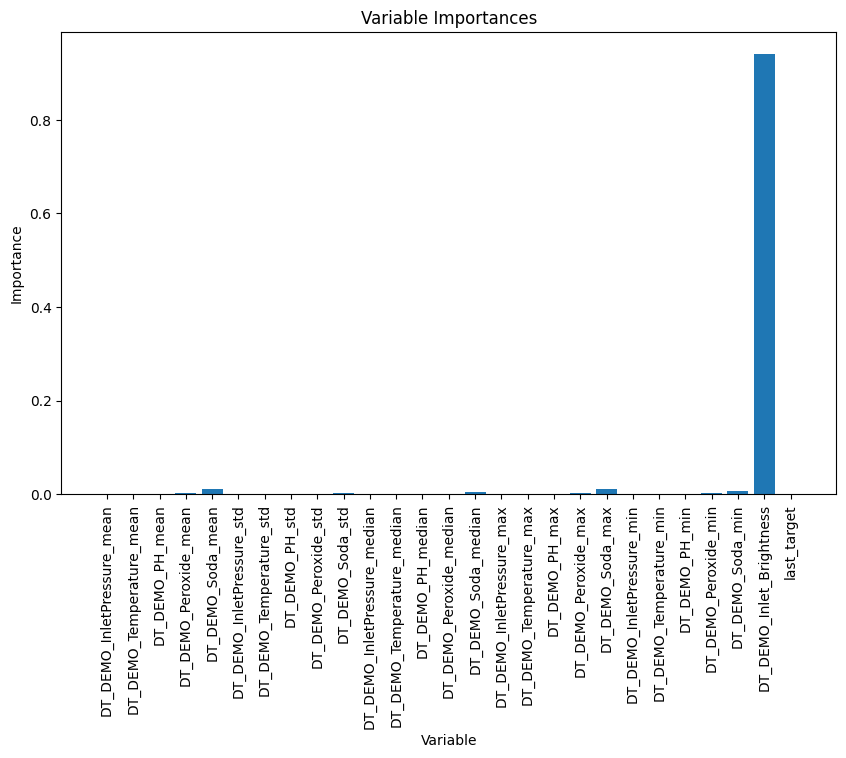

In [19]:
# Overall, method 2 (embedded method) performs better than the other one, we can take a look at its feature importance

# feature importance
importances = list(best_rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

# plot feature importance
plt.figure(figsize=(10, 6))
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, x_train.columns, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

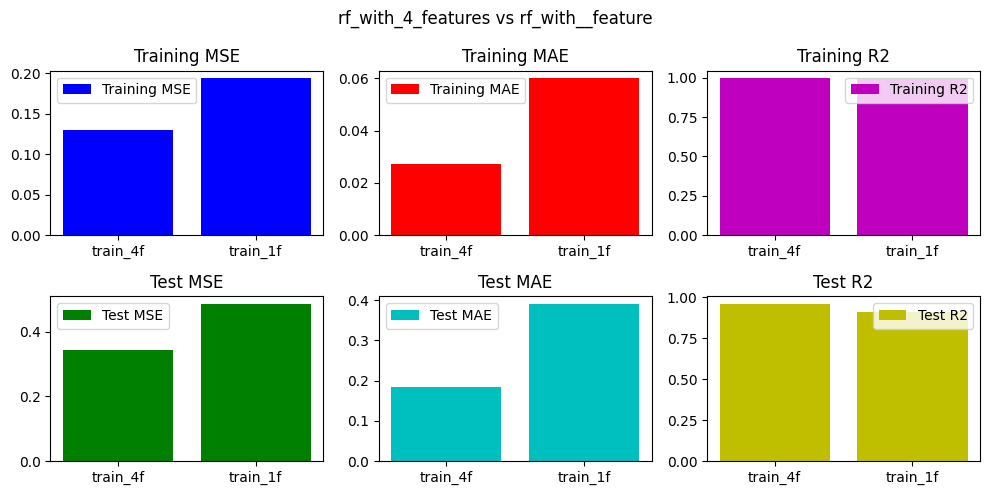

In [20]:
# we can choose the most importance features and train the model again

# as mean and media value of DT_DEMO_Soda are highly correlated, we can drop one of them
delay = '03:45:00'
important_features_4f = ["DT_DEMO_Inlet_Brightness", "DT_DEMO_Soda_mean", "DT_DEMO_Soda_max", "DT_DEMO_Soda_min"]
important_features_1f = ["DT_DEMO_Inlet_Brightness"]

# with 4 features
training_dataset = get_input_df(delay, df_input, df_target)
x_train, y_train, x_test, y_test = split_dataset(training_dataset, important_features_4f)
rf, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test = train_rf(x_train, y_train, x_test, y_test)
results_4f = [['train_4f', mse_train, mae_train, r2_train], ['test_4f', mse_test, mae_test, r2_test]]

# with 1 feature
training_dataset = get_input_df(delay, df_input, df_target)
x_train, y_train, x_test, y_test = split_dataset(training_dataset, important_features_1f)
rf, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test = train_rf(x_train, y_train, x_test, y_test)
results_1f = [['train_1f', mse_train, mae_train, r2_train], ['test_1f', mse_test, mae_test, r2_test]]


plot_bar(results_4f, results_1f, 'rf_with_4_features vs rf_with__feature', 1)

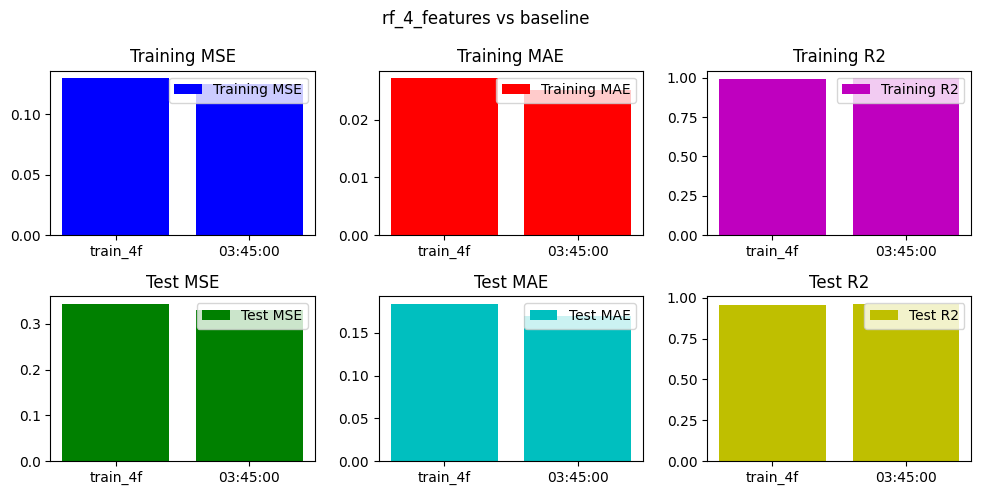

In [21]:
# apparently, the model with 4 features performs better than the one with 1 feature, then we also compare it to the baseline model
plot_bar(results_4f, best_results2, "rf_4_features vs baseline", 1)
# the difference is not significant, so we can choose the model with 4 feature in order to save time and space

# 3. training ML models

In [22]:
# now we can do a grid search to find the best parameters for the model

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

training_dataset = get_input_df(delay, df_input, df_target)
x_train, y_train, x_test, y_test = split_dataset(training_dataset, important_features_4f)


# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)
best_random = rf_random.best_estimator_
print(rf_random.best_score_)
print(rf_random.best_params_)

y_pred_train = best_random.predict(x_train)
y_pred_test = best_random.predict(x_test)
mse_train, mae_train, r2_train = metrics(y_train, y_pred_train)
mse_test, mae_test, r2_test = metrics(y_test, y_pred_test)
results_grid = [['rf_grid', mse_train, mae_train, r2_train], ['rf_grid', mse_test, mae_test, r2_test]]

print("mse_train: ", mse_train)
print("mae_train: ", mae_train)
print("r2_train: ", r2_train)
print("mse_test: ", mse_test)
print("mae_test: ", mae_test)
print("r2_test: ", r2_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
0.9575204213335388
{'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
mse_train:  0.027116099470774584
mae_train:  0.1297348611340773
r2_train:  0.9947868947240772
mse_test:  0.19229097102099682
mae_test:  0.34477422856959455
r2_test:  0.9549804552754189


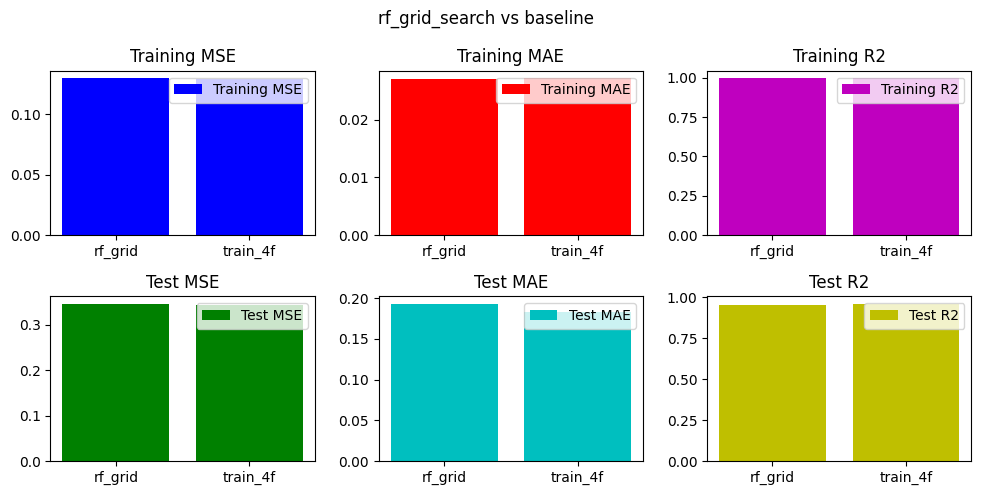

In [23]:
plot_bar(results_grid, results_4f, 'rf_grid_search vs baseline', 1)
# we can see that the grid search does not improve the model, so we can use the model with 4 features and default parameters

In [24]:
#save the model
filename = 'rf_model.sav'
pickle.dump(best_rf, open(filename, 'wb'))

In [25]:
# train xgboost model


def train_xgb(x_train, y_train, x_test, y_test, n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42):
    xgb_model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=random_state)
    xgb_model.fit(x_train, y_train)
    y_pred_train = xgb_model.predict(x_train)
    y_pred_test = xgb_model.predict(x_test)
    mse_train, mae_train, r2_train = metrics(y_train, y_pred_train)
    mse_test, mae_test, r2_test = metrics(y_test, y_pred_test)
    return xgb_model, [["xgb", mse_train, mae_train, r2_train], ["xgb", mse_test, mae_test, r2_test]]

xgb_model, xgb_results = train_xgb(x_train, y_train, x_test, y_test)

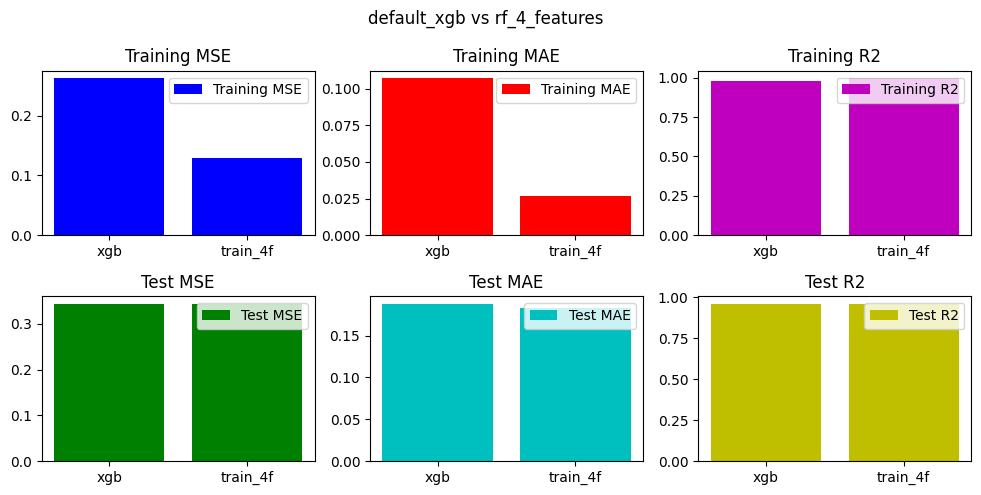

[['xgb', 0.10701370784233318, 0.2620294736510428, 0.9794264759372863], ['xgb', 0.18750250220239378, 0.34199145980669926, 0.9561015411225429]]
[['train_4f', 0.02712898828818017, 0.1295371173342624, 0.9947844168322223], ['test_4f', 0.18318793678048262, 0.34230441236093667, 0.9571116757635378]]


In [26]:
plot_bar(xgb_results, results_4f, "default_xgb vs rf_4_features", 1)
print(xgb_results)
print(results_4f)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.961742766514221


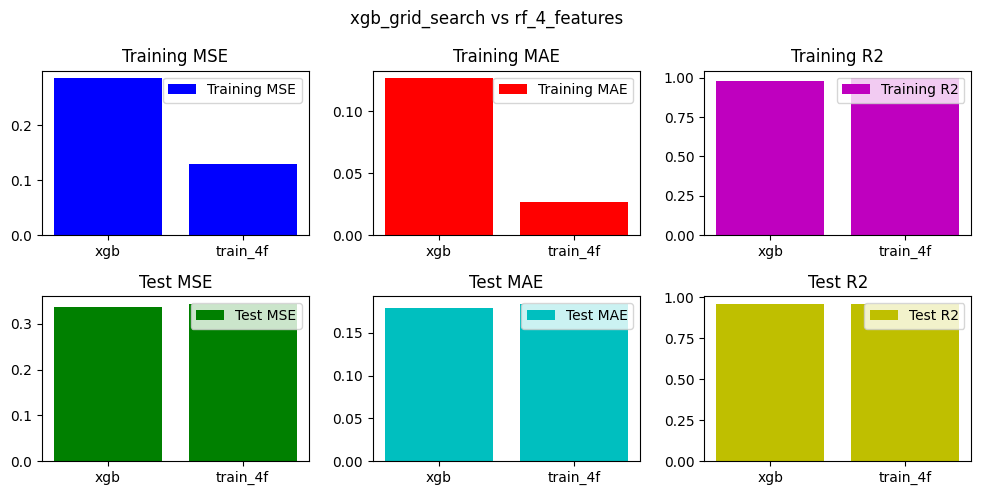

[['xgb', 0.12637504030730543, 0.2851262111872941, 0.9757042346713245], ['xgb', 0.17856369526560398, 0.33683327589265355, 0.9581943123875611]]
[['train_4f', 0.02712898828818017, 0.1295371173342624, 0.9947844168322223], ['test_4f', 0.18318793678048262, 0.34230441236093667, 0.9571116757635378]]


In [27]:
# default xgb model is not as good as the baseline, so we can do a grid search on the parameters
# grid search for xgboost
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001]
}

xgb_model = xgb.XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
xgb_best = grid_search.best_estimator_
y_pred_train = xgb_best.predict(x_train)
y_pred_test = xgb_best.predict(x_test)
mse_train, mae_train, r2_train = metrics(y_train, y_pred_train)
mse_test, mae_test, r2_test = metrics(y_test, y_pred_test)
xgb_results_grid = [["xgb", mse_train, mae_train, r2_train], ["xgb", mse_test, mae_test, r2_test]]

plot_bar(xgb_results_grid, results_4f, "xgb_grid_search vs rf_4_features", 1)
print(xgb_results_grid)
print(results_4f)
# finally, xgb over-performs a little bit over baseline random forest
# as xgboost is a lighter model, it takes less space amd excution time

In [29]:
# save the model
filename = 'xgb_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

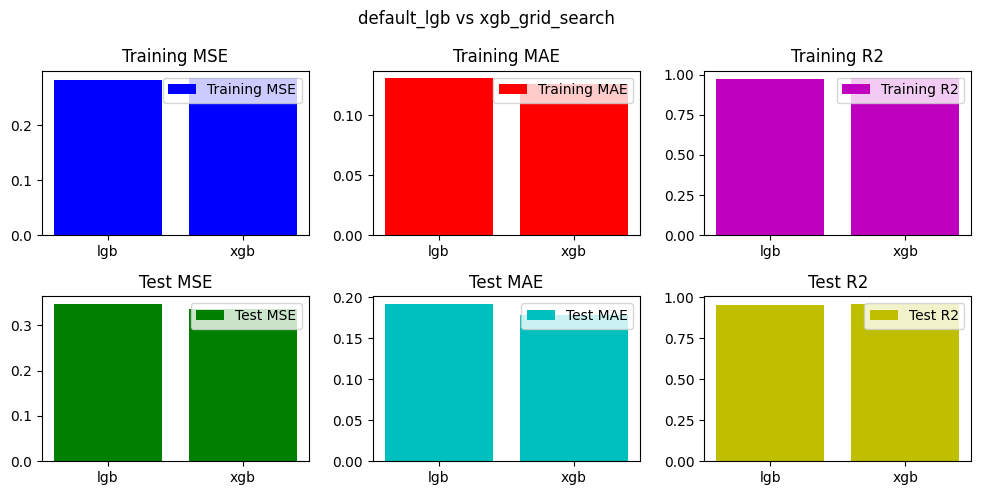

In [30]:
# train a lightgbm model

def train_lgb(x_train, y_train, x_test, y_test, n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42):
    lgb_model = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=random_state)
    lgb_model.fit(x_train, y_train)
    y_pred_train = lgb_model.predict(x_train)
    y_pred_test = lgb_model.predict(x_test)
    mse_train, mae_train, r2_train = metrics(y_train, y_pred_train)
    mse_test, mae_test, r2_test = metrics(y_test, y_pred_test)
    return lgb_model, [["lgb", mse_train, mae_train, r2_train], ["lgb", mse_test, mae_test, r2_test]]

lgb_model, lgb_results = train_lgb(x_train, y_train, x_test, y_test)
plot_bar(lgb_results, xgb_results_grid, 'default_lgb vs xgb_grid_search', 1)
# default lgb is not as good as xgb model

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 931, number of used features: 4
[LightGBM] [Info] Start training from score 89.291850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

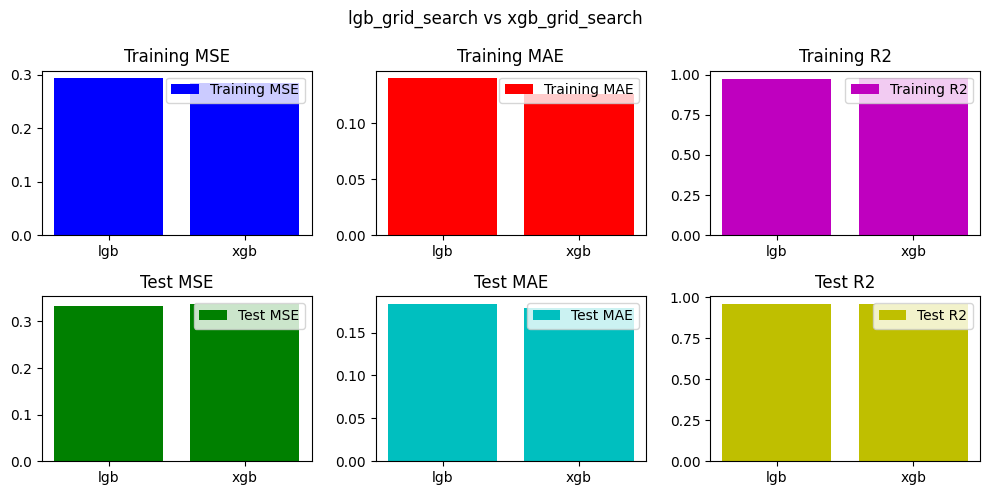

[['lgb', 0.1401303545685751, 0.2927901540546375, 0.9730597576725332], ['lgb', 0.18287903233268793, 0.3338742428906041, 0.957183997087463]]
[['xgb', 0.12637504030730543, 0.2851262111872941, 0.9757042346713245], ['xgb', 0.17856369526560398, 0.33683327589265355, 0.9581943123875611]]


In [31]:
# grid search for lightgbm
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001]
}

lgb_model = lgb.LGBMRegressor(random_state=42)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
lgb_model = grid_search.best_estimator_
y_pred_train = lgb_model.predict(x_train)
y_pred_test = lgb_model.predict(x_test)
mse_train, mae_train, r2_train = metrics(y_train, y_pred_train)
mse_test, mae_test, r2_test = metrics(y_test, y_pred_test)
lgb_results_grid = [["lgb", mse_train, mae_train, r2_train], ["lgb", mse_test, mae_test, r2_test]]

plot_bar(lgb_results_grid, xgb_results_grid, 'lgb_grid_search vs xgb_grid_search', 1)
print(lgb_results_grid)
print(xgb_results_grid)

# xgb is still better than lgb, so we can choose xgb as our final model

## k-fold validation

In [32]:
# as we can see in the figures of xgb_grid_search (e.g. lgb_grid_search vs xgb_grid_search), there is a overfitting lying in the xgboost model, we can try to correct it with k-fold validation
# Create the XGBRegressor
xgb_model = xgb.XGBRegressor(n_estimators=500, max_depth=3, learning_rate=0.01, random_state=42)

# Create a 10-fold cross-validation object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define scoring functions
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation for MSE, MAE and R2
mse_cv_results = cross_val_score(xgb_model, x_train, y_train, cv=kf, scoring=mse_scorer)
mae_cv_results = cross_val_score(xgb_model, x_train, y_train, cv=kf, scoring=mae_scorer)
r2_cv_results = cross_val_score(xgb_model, x_train, y_train, cv=kf, scoring=r2_scorer)

# Display the results
print("Cross-Validation Results:")
print("MSE:", mse_cv_results)
print("MAE:", mae_cv_results)
print("R2:", r2_cv_results)

Cross-Validation Results:
MSE: [0.23629477 0.19482401 0.18710703 0.17120502 0.15544639 0.21864135
 0.13406947 0.18741911 0.19301904 0.17418949]
MAE: [0.37212528 0.34375308 0.35617124 0.33587323 0.3175717  0.38141877
 0.28745912 0.3378867  0.35016329 0.34279864]
R2: [0.96297973 0.95727843 0.9648466  0.95826667 0.97135107 0.96335111
 0.96914281 0.97146067 0.95953061 0.95943391]


In [33]:
# the 6th fold is the best one,  we can split the dataset

fold_index = 6  # Remember, indexing starts from 0

# Split the data into training and validation sets for the specified fold
for i, (train_index, val_index) in enumerate(kf.split(x_train)):
    if i == fold_index:
        X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        break
xgb_model.fit(X_train_fold, y_train_fold)
y_val_pred = xgb_model.predict(x_test)
mse_fold = mean_squared_error(y_test, y_val_pred)
mae_fold = mean_absolute_error(y_test, y_val_pred)
r2_fold = r2_score(y_test, y_val_pred)

kfold_results = ["k-fold", mse_fold, mae_fold, r2_fold]

print("MSE:", mse_fold)
print("MAE:", mae_fold)
print("R2:", r2_fold)

MSE: 0.17653145137848492
MAE: 0.33467869850648807
R2: 0.9586701053698402


In [34]:
# plot bar figures of test results
def plot_test_bar(results1, results2, title=None, is_name=0):
    # Unpack the results into separate lists
    name1, test_mae1, test_mse1, test_r21 = results1
    name2, test_mae2, test_mse2, test_r22 = results2
    # tranfer to float
    test_mae1 = float(test_mae1)
    test_mse1 = float(test_mse1)
    test_r21 = float(test_r21)
    test_mae2 = float(test_mae2)
    test_mse2 = float(test_mse2)
    test_r22 = float(test_r22)
    # put the values into lists
    test_mses = [test_mse1, test_mse2]
    test_maes = [test_mae1, test_mae2]
    test_r2s = [test_r21, test_r22]
    methods = ['method 1', 'method 2']
    if is_name:
      methods = [name1, name2]

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    # Plot Test MSE
    axs[0].bar(methods, test_mses, color='g', label='Test MSE')
    axs[0].set_title('Test MSE')
    axs[0].legend()

    # Plot Test MAE
    axs[1].bar(methods, test_maes, color='c', label='Test MAE')
    axs[1].set_title('Test MAE')
    axs[1].legend()

    # Plot Test R2
    axs[2].bar(methods, test_r2s, color='y', label='Test R2')
    axs[2].set_title('Test R2')
    axs[2].legend()

    # Add labels and adjust layout
    if title is not None:
      fig.suptitle(title)
    plt.tight_layout()

    # Show the plot
    plt.show()

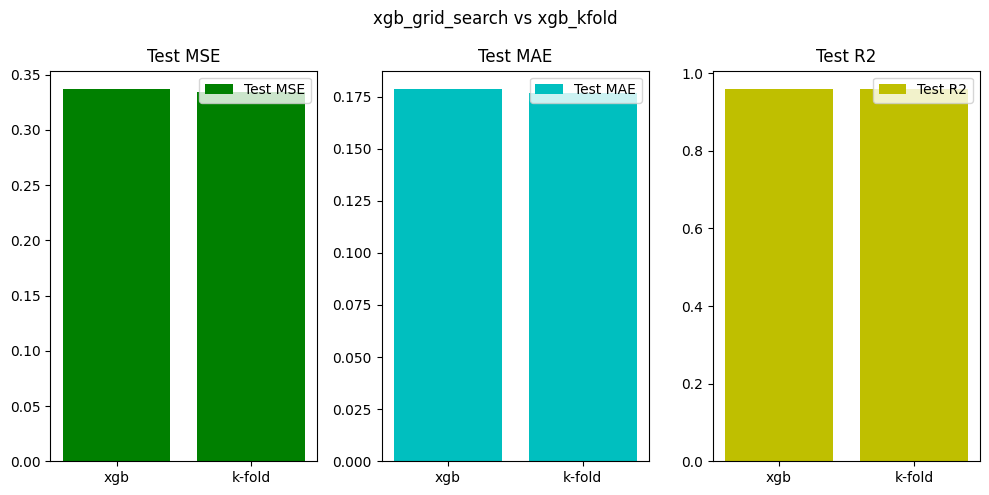

['xgb', 0.17856369526560398, 0.33683327589265355, 0.9581943123875611]
['k-fold', 0.17653145137848492, 0.33467869850648807, 0.9586701053698402]


In [35]:
plot_test_bar(xgb_results_grid[1], kfold_results, 'xgb_grid_search vs xgb_kfold', 1)
print(xgb_results_grid[1])
print(kfold_results)
# the k-folded xgboost model is a little bit better

# 4. deep learning (lstm)
deep learning will do features extraction itself instead of manual selection

In [36]:
training_dataset = get_input_df(propogation_delays[1], df_input, df_target)
df_deep = training_dataset[["DT_DEMO_InletPressure_mean","DT_DEMO_Temperature_mean","DT_DEMO_PH_mean","DT_DEMO_Peroxide_mean","DT_DEMO_Soda_mean","DT_DEMO_Inlet_Brightness","target"]]

# Normalize the data
# unlike tree - like models, deep learning models prefer normalized data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_deep), columns=df_deep.columns)

# Split the data into training and test sets
train_data, test_data = train_test_split(df_scaled, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
train_features = torch.tensor(train_data.iloc[:, :-1].values, dtype=torch.float32).view(-1, 1, df_deep.shape[1] - 1)
train_target = torch.tensor(train_data.iloc[:, -1].values, dtype=torch.float32).view(-1, 1)

test_features = torch.tensor(test_data.iloc[:, :-1].values, dtype=torch.float32).view(-1, 1, df_deep.shape[1] - 1)
test_target = torch.tensor(test_data.iloc[:, -1].values, dtype=torch.float32).view(-1, 1)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model
input_size = df_deep.shape[1] - 1
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_features)
    loss = criterion(outputs, train_target)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(test_features)
    test_loss = criterion(test_outputs, test_target)

print(f'Test Loss: {test_loss.item():.4f}')

# Inverse transform to get the actual predictions
test_predicted = scaler.inverse_transform(
    np.concatenate((test_features.view(-1, input_size).numpy(), test_outputs.numpy()), axis=1))[:, -1]

# Inverse transform the actual target values
test_actual = scaler.inverse_transform(
    np.concatenate((test_features.view(-1, input_size).numpy(), test_target.numpy()), axis=1))[:, -1]

Epoch [100/1000], Loss: 0.0166
Epoch [200/1000], Loss: 0.0070
Epoch [300/1000], Loss: 0.0049
Epoch [400/1000], Loss: 0.0052
Epoch [500/1000], Loss: 0.0050
Epoch [600/1000], Loss: 0.0045
Epoch [700/1000], Loss: 0.0042
Epoch [800/1000], Loss: 0.0041
Epoch [900/1000], Loss: 0.0039
Epoch [1000/1000], Loss: 0.0038
Test Loss: 0.0008


In [37]:
# Print actual vs predicted values for the test set
differences = []
err_percentages = []
for actual, predicted in zip(test_actual, test_predicted):
    differences.append(abs(actual-predicted))
for difference, actual in zip(differences, test_actual):
  err_percentages.append(difference/actual)

In [38]:
mse = mean_squared_error(test_actual, test_predicted)
mae = mean_absolute_error(test_actual, test_predicted)
r2 = r2_score(test_actual, test_predicted)

lstm_results = ["lstm_default", mse, mae, r2]

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared (R2): {r2:.4f}')



Mean Squared Error (MSE): 0.1706
Mean Absolute Error (MAE): 0.3231
R-squared (R2): 0.9601


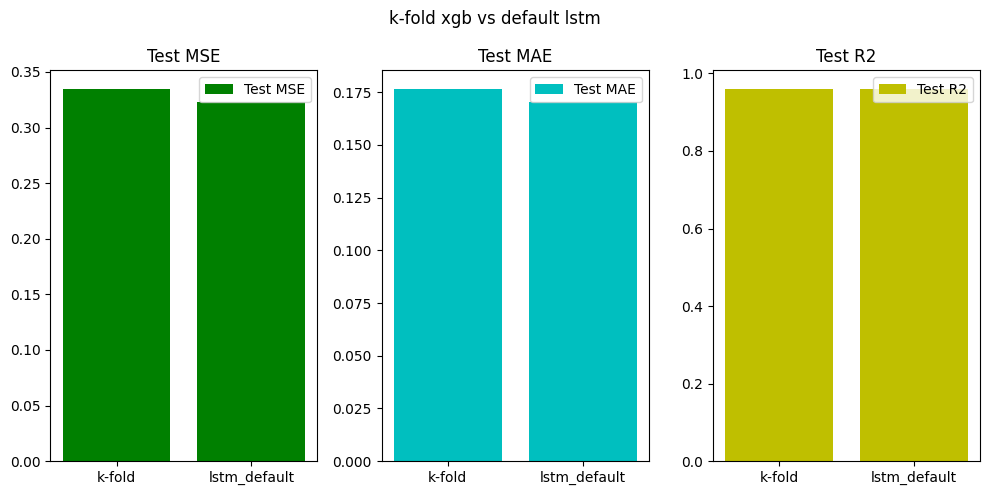

In [39]:
plot_test_bar(kfold_results, lstm_results, "k-fold xgb vs default lstm", 1)
# lstm is even better than the xgboost model

In [40]:
# visualize the range of errors and their distibutions

# Define the bin edges for histogram bins
bin_edges = np.arange(0, 1.1, 0.1).tolist() + [float('inf')]

# Use numpy's histogram function to count occurrences in each bin
hist, bin_edges = np.histogram(differences, bins=bin_edges)

# Calculate percentages
total_count = len(differences)
percentages = (hist / total_count) * 100

# Create a dataframe for Plotly
data = {'Range': [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(len(percentages))], 'Percentage': percentages}
df = pd.DataFrame(data)

# Create a bar plot using Plotly Express
fig = px.bar(df, x='Range', y='Percentage', title='Distribution of Differences', labels={'Percentage': 'Percentage (%)'})

# Show the plot
fig.show()

In [42]:
# Define the bin edges for histogram bins
bin_edges = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, float('inf')]

# Use numpy's histogram function to count occurrences in each bin
hist, bin_edges = np.histogram(err_percentages, bins=bin_edges)

# Calculate percentages
total_count = len(err_percentages)
percentages = (hist / total_count) * 100

# Create a dataframe for Plotly
data = {'Range': [f'{bin_edges[i]:.4f}-{bin_edges[i+1]:.4f}' for i in range(len(percentages))], 'Percentage': percentages}
df = pd.DataFrame(data)

# Create a bar plot using Plotly Express
fig = px.bar(df, x='Range', y='Percentage', title='Distribution of Error Percentages', labels={'Percentage': 'Percentage (%)'})

# Show the plot
fig.show()

we can say most of the predictions gives a prediction of high quality

In [43]:
filename = 'lstm.pt'
torch.save(model,filename)